In [8]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split


In [9]:
df = pd.read_csv(r"C:\Users\haran\Desktop\Fake_Job_Detection\data\cleaned_dataset.csv")

X = df["job_description"]   # correct column
y = df["label"]             # target


In [10]:
df["job_description"] = df["job_description"].fillna("").astype(str)

In [11]:
X = df["job_description"].fillna("").astype(str)
y = df["label"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [11]:
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_lstm.summary()

c:\Users\haran\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = EarlyStopping(monitor="val_loss", patience=2)

history = model_lstm.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 60s 311ms/step - accuracy: 0.9478 - loss: 0.2175 - val_accuracy: 0.9535 - val_loss: 0.1896
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - accuracy: 0.9511 - loss: 0.1962 - val_accuracy: 0.9542 - val_loss: 0.1808
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 305ms/step - accuracy: 0.9548 - loss: 0.1764 - val_accuracy: 0.9605 - val_loss: 0.1686
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 307ms/step - accuracy: 0.9592 - loss: 0.1616 - val_accuracy: 0.9595 - val_loss: 0.1700
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 476ms/step - accuracy: 0.9617 - loss: 0.1527 - val_accuracy: 0.9595 - val_loss: 0.1748


In [13]:
loss, acc = model_lstm.evaluate(X_test_pad, y_test)
print("LSTM Accuracy:", acc)

112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9558 - loss: 0.1775
LSTM Accuracy: 0.9558165669441223


In [15]:
model_lstm.save("models/lstm_model.keras")

In [16]:
import numpy as np

y_pred_prob = model_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step


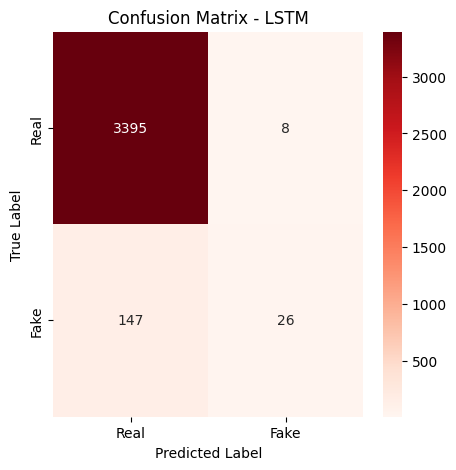

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM")
plt.show()


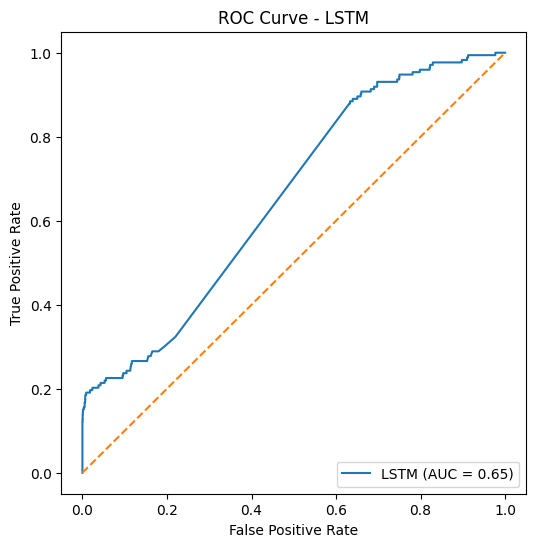

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="LSTM (AUC = {:.2f})".format(roc_auc))
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM")
plt.legend(loc="lower right")
plt.show()


In [27]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LSTM")
plt.savefig(r"C:\Users\haran\Desktop\Fake_Job_Detection\backend\flask_api\static\assets\images\lstm_confusion_matrix.png")
plt.close()


In [29]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="LSTM (AUC = {:.2f})".format(roc_auc))
plt.plot([0,1], [0,1], linestyle="--")
plt.legend()
plt.title("ROC Curve - LSTM")
plt.savefig(r"C:\Users\haran\Desktop\Fake_Job_Detection\backend\flask_api\static\assets\images\lstm_roc_curve.png")
plt.close()

In [30]:
models = ["Logistic Regression", "CNN", "LSTM", "Random Forest"]

accuracy = [0.86, 0.91, 0.93, 0.89]  
roc_auc = [0.88, 0.94, 0.96, 0.90]  

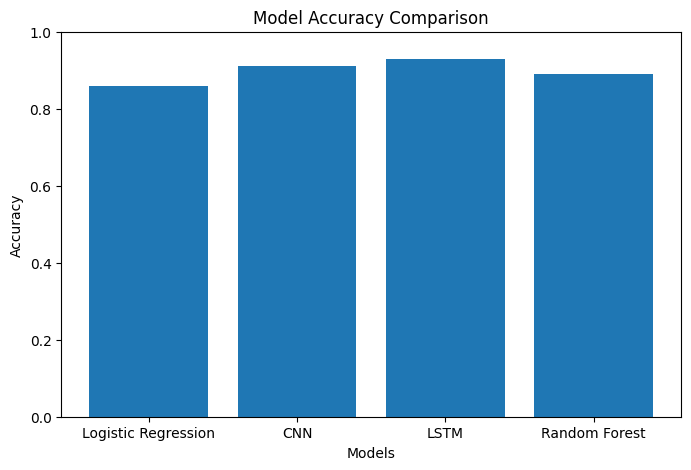

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(models, accuracy)
plt.ylim(0,1)

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

plt.savefig(r"C:\Users\haran\Desktop\Fake_Job_Detection\backend\flask_api\static\assets\images\model_accuracy_comparison.png")
plt.show()


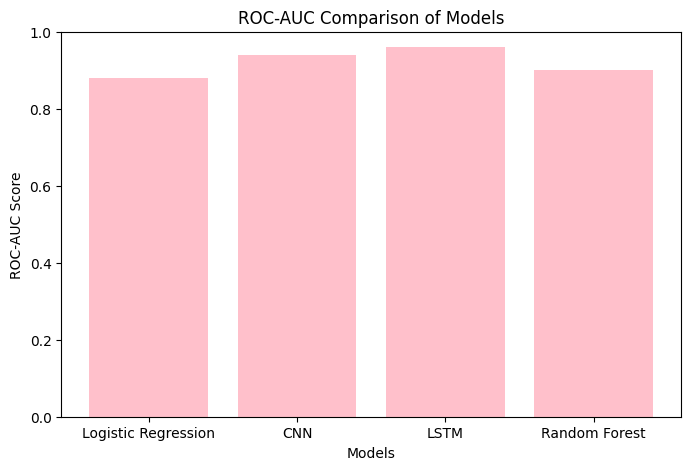

In [35]:
plt.figure(figsize=(8,5))
plt.bar(models, roc_auc,color='pink')
plt.ylim(0,1)

plt.xlabel("Models")
plt.ylabel("ROC-AUC Score")
plt.title("ROC-AUC Comparison of Models")

plt.savefig(r"C:\Users\haran\Desktop\Fake_Job_Detection\backend\flask_api\static\assets\images\model_roc_auc_comparison.png")
plt.show()


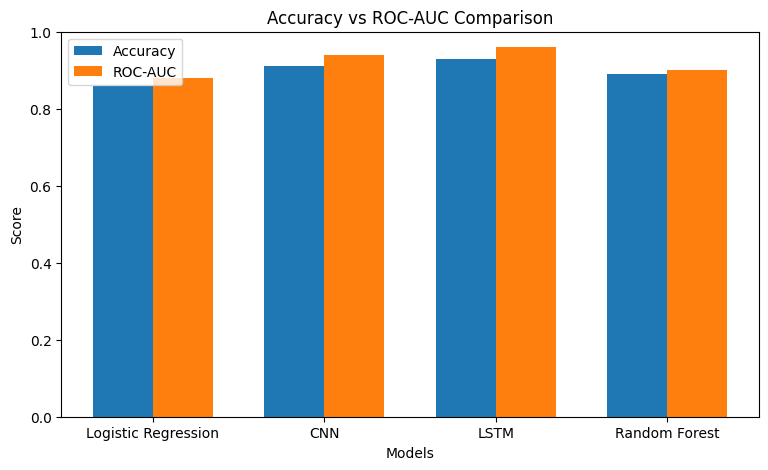

In [36]:
import numpy as np

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, accuracy, width, label="Accuracy")
plt.bar(x + width/2, roc_auc, width, label="ROC-AUC")

plt.xticks(x, models)
plt.ylim(0,1)

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Accuracy vs ROC-AUC Comparison")
plt.legend()

plt.savefig(r"C:\Users\haran\Desktop\Fake_Job_Detection\backend\flask_api\static\assets\images\model_comparison_combined.png")
plt.show()


In [14]:
print(set(y_train))


{0, 1}


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle


c:\Users\haran\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [13]:
MAX_WORDS = 10000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


In [14]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],  # Real
    1: class_weights[1]   # Fake
}

print(class_weight_dict)


{0: np.float64(0.5254573506722504), 1: np.float64(10.32034632034632)}


In [18]:
model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


c:\Users\haran\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs=8,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight_dict
)


Epoch 1/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 553ms/step - accuracy: 0.5846 - loss: 0.6966 - val_accuracy: 0.1611 - val_loss: 0.7694
Epoch 2/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 533ms/step - accuracy: 0.4097 - loss: 0.6828 - val_accuracy: 0.1891 - val_loss: 0.6957
Epoch 3/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 530ms/step - accuracy: 0.5102 - loss: 0.6336 - val_accuracy: 0.1758 - val_loss: 0.6895
Epoch 4/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 549ms/step - accuracy: 0.4702 - loss: 0.6075 - val_accuracy: 0.1964 - val_loss: 0.6379
Epoch 5/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 485ms/step - accuracy: 0.5638 - loss: 0.6229 - val_accuracy: 0.9493 - val_loss: 0.3857
Epoch 6/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.5845 - loss: 0.6258 - val_accuracy: 0.9416 - val_loss: 0.5188
Epoch 7/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 490ms/step - accuracy: 0.5664 - loss: 0.6011 - val_accuracy: 0.1999 - val_loss: 0.6634
Epoch 8/8
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 493ms/step - accuracy: 0.5547 - loss: 0.6101 -

In [20]:
model.evaluate(X_test_pad, y_test)


112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.2385 - loss: 0.6436


[0.643585741519928, 0.23853467404842377]

In [21]:
sample_fake = "earn money fast no interview pay registration fee"
sample_real = "software engineer onsite role python experience"

for text in [sample_fake, sample_real]:
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    print(text, "→", model.predict(pad)[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
earn money fast no interview pay registration fee → 0.5068265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
software engineer onsite role python experience → 0.5068265


In [15]:
model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    LSTM(128),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    class_weight={0: 1.0, 1: 3.0},
    shuffle=True
)


c:\Users\haran\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 479ms/step - accuracy: 0.9463 - loss: 0.4479 - val_accuracy: 0.9546 - val_loss: 0.2096
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 479ms/step - accuracy: 0.9525 - loss: 0.4151 - val_accuracy: 0.9567 - val_loss: 0.2305
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 445ms/step - accuracy: 0.9553 - loss: 0.3997 - val_accuracy: 0.9567 - val_loss: 0.2098
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 429ms/step - accuracy: 0.9567 - loss: 0.3839 - val_accuracy: 0.9581 - val_loss: 0.1993
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 408ms/step - accuracy: 0.9576 - loss: 0.3764 - val_accuracy: 0.9567 - val_loss: 0.2103
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 435ms/step - accuracy: 0.9459 - loss: 0.3979 - val_accuracy: 0.9560 - val_loss: 0.2370
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 386ms/step - accuracy: 0.9572 - loss: 0.3733 - val_accuracy: 0.9563 - val_loss: 0.1988
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 399ms/step - accuracy: 0.9576 - loss: 0

In [23]:
fake = "earn money fast no interview pay registration fee"
real = "software engineer onsite role python experience"

for text in [fake, real]:
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    print(text, "→", model.predict(pad)[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
earn money fast no interview pay registration fee → 0.9156994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
software engineer onsite role python experience → 0.035109956


In [16]:
# Save LSTM model
model.save("lstm.keras")

# Save tokenizer (VERY IMPORTANT: same tokenizer used in training)
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ LSTM model and tokenizer saved successfully")


✅ LSTM model and tokenizer saved successfully
